In [1]:
#Really need these
import pandas as pd 
import numpy as np
from numpy import *


import time
import os

#Date stuff
from datetime import datetime
from datetime import timedelta

#Do some statistics
#from scipy.misc import imread
from scipy import sparse
import scipy.stats as ss
import math

#Nice graphing tools
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
"""
import plotly
import plotly.offline as py
import plotly.tools as tls
import plotly.graph_objs as go
import plotly.tools as tls"""

#Machine learning tools
from sklearn.ensemble import RandomForestRegressor
from sklearn.utils.validation import check_X_y, check_is_fitted
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from scipy import sparse

## Performance measures
from sklearn.metrics import mean_squared_error



In [2]:
np.random.seed(100) #set the seed for random generator

In [3]:

def read_data(): #read the initial data
    train = pd.read_csv('wl.csv')
    test = pd.read_csv('wl_test.csv')
    train['Split'] = 'Train'
    test['Split'] = 'Test'
    return train,test


In [4]:
def model_dataset_split(df):
    df['Difference'] = df['Median Sales'] - df['Weekly_Sales']
    train = df.loc[df['Split']=='Train']
    test = df.loc[df['Split']=='Test']
    X_train, X_dev, y_train, y_dev = train_test_split(train[cols_needed], train['Difference'], test_size=0.2, random_state=42)
    return X_train,X_dev,y_train,y_dev,test,train

In [5]:
def plot_corr(df):
    f, ax = plt.subplots(figsize=(10, 8))
    mask = np.zeros_like(df.corr())
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(df.corr(), mask=mask, cmap=sns.light_palette("navy"), linewidths=.75 )


In [6]:

def results_randomForest(y_dev,train) :
    y_dev['Predicted'] = y_pred_random
    df_out = pd.merge(train,y_dev[['Predicted']],how = 'left',left_index = True, right_index = True,suffixes=['_True','_Pred'])
    df_out = df_out[~pd.isnull(df_out['Predicted'])]
    return df_out,train

In [7]:
def get_sales_diff(df):
    df['Sales_dif'] = df['Median Sales'] - df['LaggedSales']
    
    return df

In [8]:
def plot_feature_importance(data_model,cols_needed,rf_model):
    f_name=[]
    f_imp=[]
    c=0
    myzip=zip(cols_needed, rf_model.feature_importances_)
    f, ax = plt.subplots(figsize=(10, 8))
    for name, importance in sorted(myzip, key=lambda x: x[1],reverse=True):
        f_name.append(name)
        f_imp.append(importance)
        if(c==5):
            break
        c+=1
    width = 1/2
    plt.bar(f_name, f_imp, width, color="navy")

In [9]:
from matplotlib.pyplot import *
def generate_scatter_plots(df,feature):
    scatter(df[feature], df['Weekly_Sales'],alpha=0.5,color='blue')

In [10]:
def feature_engineer_markdown(df):
    df = df.assign(md1_present = df.MarkDown1.notnull())
    df = df.assign(md2_present = df.MarkDown2.notnull())
    df = df.assign(md3_present = df.MarkDown3.notnull())
    df = df.assign(md4_present = df.MarkDown4.notnull())
    df = df.assign(md5_present = df.MarkDown5.notnull())
    df.fillna(0, inplace=True)
    return df

In [11]:
def add_dummies(df,feature):
    df[feature]=feature+'_'+df[feature].map(str)
    feature_dummy=pd.get_dummies(df[feature])
    df=pd.concat([df,feature_dummy],axis=1)
    return df

In [12]:
def add_median_stats(df):
    medians = pd.DataFrame({'Median Sales' :df.loc[df['Split']=='Train'].groupby(by=['Type','Dept','Store','Month','IsHoliday'])['Weekly_Sales'].median()}).reset_index()
    df = df.merge(medians, how = 'outer', on = ['Type','Dept','Store','Month','IsHoliday'])
    df['Median Sales'].fillna(df['Median Sales'].loc[df['Split']=='Train'].median(), inplace=True) 
    df['Key'] = df['Type'].map(str)+df['Dept'].map(str)+df['Store'].map(str)+df['Date'].map(str)+df['IsHoliday'].map(str)
    return df,medians

In [13]:
def binary(movement):
    direction = np.empty(movement.shape[0])
    #change in price > zero, direction=1
    #change in price < zero, direction=0
    for i in range(movement.shape[0]):
        if movement[i] > 0:
            direction[i] = 1
        else:
            direction[i]= 0
    return direction

In [14]:
#http://scikit-learn.org/stable/auto_examples/plot_cv_predict.html
def plot_prediction(predicted,true,desciption):
    fig, ax = plt.subplots()
    ax.scatter(true, predicted, edgecolors=(0, 0, 0))
    ax.plot([true.min(), true.max()], [true.min(), true.max()], 'k--', lw=4)
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted by '+desciption)
    ax.plot([-30,30], [0,0], 'k-')   
    ax.plot([0,0], [-30,30], 'k-')
    plt.show()


In [15]:
def train_RandomForest(X_train, y_train):
    #declare the model with specifics
    regr = RandomForestRegressor(n_estimators=20, criterion='mse', max_depth=None, 
                      min_samples_split=2, min_samples_leaf=1, 
                      min_weight_fraction_leaf=0.0, max_features='auto', 
                      max_leaf_nodes=None, min_impurity_decrease=0.0, 
                      min_impurity_split=None, bootstrap=True, 
                      oob_score=False, n_jobs=1, random_state=None, 
                      verbose=2, warm_start=False)

    #Train on data
    regr.fit(X_train, y_train.ravel())
    return regr

In [16]:
def predict_RandomForest(test,regr):
    y_pred_random = regr.predict(test)
    return y_pred_random

def add_previous_week(df): 
    df['DateLagged'] = df['DateType']- timedelta(days=7)
    return df

def create_sorted_df(df):
    sorted_df = df.sort_values(['Store', 'Dept','DateType'], ascending=[1, 1,1])
    sorted_df = sorted_df.reset_index(drop=True) # Reinitialize the row indices for the loop to work
    return sorted_df

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Split
0,26,92,8/26/2011,87235.57,False,61.10,3.796,NaN,NaN,NaN,NaN,NaN,136.213613,7.767,A,152513.0,Train
1,34,22,3/25/2011,5945.97,False,53.11,3.480,NaN,NaN,NaN,NaN,NaN,128.616064,10.398,A,158114.0,Train
2,21,28,12/3/2010,1219.89,False,50.43,2.708,NaN,NaN,NaN,NaN,NaN,211.265543,8.163,B,140167.0,Train
3,8,9,9/17/2010,11972.71,False,75.32,2.582,NaN,NaN,NaN,NaN,NaN,214.878556,6.315,A,155078.0,Train
4,19,55,5/18/2012,8271.82,False,58.81,4.029,12613.98,NaN,11.5,1705.28,3600.79,138.106581,8.150,A,203819.0,Train


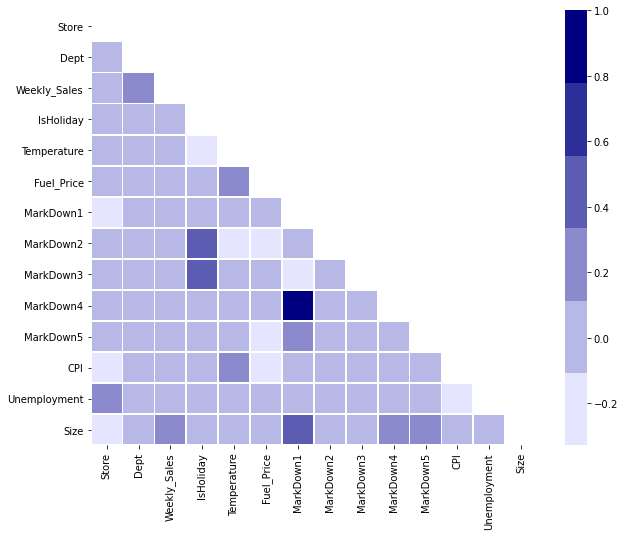

In [17]:

train,test=read_data()
df = pd.concat([train,test],axis=0) # Join train and test

plot_corr(df) #plot correlation matrix of the raw dataset


#generate_scatter_plots(df,'Type')
# from the  graph, one key observation is type C has less sales


df.head()

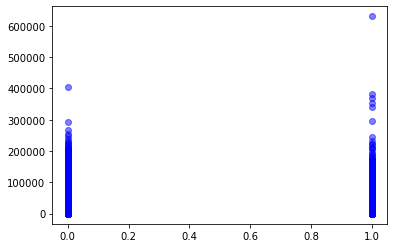

In [18]:
generate_scatter_plots(df,'IsHoliday') #sales are higher if its a holiday

In [19]:
#With the below plots, we will be able to see that the following features don't show too much differences (atleast not by direct data visualization)
#This is expected because the features below should not have an influence on sales (by logic)
#Commenting the below data analysis to reduce processing time

#generate_scatter_plots(df,'Temperature')
#generate_scatter_plots(df,'Fuel_Price')

#Lets start feature engineering
df=feature_engineer_markdown(df) #lets stark with mardown feature

df['Type'] = 'Type_' + df['Type'].map(str)
df['Store'] = 'Store_' + df['Store'].map(str)
df['Dept'] = 'Dept_' + df['Dept'].map(str)

# Create dummies
type_dummies = pd.get_dummies(df['Type'])
store_dummies = pd.get_dummies(df['Store'])
dept_dummies = pd.get_dummies(df['Dept'])

df['DateType'] = [datetime.strptime(date, '%m/%d/%Y').date() for date in df['Date'].astype(str).values.tolist()]
df['Month'] = [date.month for date in df['DateType']]
df['Month'] =  df['Month'].map(str)
Month_dummies = pd.get_dummies(df['Month'] )

df['Black_Friday'] = np.where((df['DateType']==datetime(2010, 11, 26).date() \
                              ) | (df['DateType']==datetime(2011, 11, 25).date()), 'yes', 'no')
df['Pre_christmas'] = np.where((df['DateType']==datetime(2010, 12, 23).date() \
                               ) | (df['DateType']==datetime(2010, 12, 24).date()) | (df['DateType']==datetime(2011, \
                            12, 23).date()) | (df['DateType']==datetime(2011, 12, 24).date()), 'yes', 'no')

for feature in ['IsHoliday','Pre_christmas','Black_Friday'] :
    df=add_dummies(df,feature)
df.head()

#Notice anything?
df.loc[df['Weekly_Sales'] >200000,"Month"].value_counts()

12    16
11    11
2      4
9      1
3      1
Name: Month, dtype: int64

In [20]:
#Now since we know the sales are so much higher on these 2 holidays,
#lets create additional features according to these 2 holiday periods

#for black friday we consider nov 25,26.
#for christmas we consider 23,24,25
df['Black_Friday'] = np.where((df['DateType']==datetime(2010, 11, 26).date()) | \
                              (df['DateType']==datetime(2011, 11, 25).date()), 'yes', 'no')
df['Pre_christmas'] = np.where((df['DateType']==datetime(2010, 12, 23).date()) | \
                               (df['DateType']==datetime(2010, 12, 24).date()) | \
                               (df['DateType']==datetime(2011, 12, 23).date()) | \
                               (df['DateType']==datetime(2011, 12, 24).date()), 'yes', 'no')
#now handle these 2 new categories

df,medians =add_median_stats(df) #lets add the median stats for type,dept,store,month,isholiday

print(medians.head())

print(df.head())

df=add_previous_week(df) #added the last weeks date as a new variables,
#we will use this to get sales of previous and compare difference in later steps

sorted_df=create_sorted_df(df)


     Type     Dept     Store Month        IsHoliday  Median Sales
0  Type_0  Dept_90  Store_29    12  IsHoliday_False     11230.730
1  Type_A   Dept_1   Store_1     1  IsHoliday_False     16439.320
2  Type_A   Dept_1   Store_1    10  IsHoliday_False     38640.930
3  Type_A   Dept_1   Store_1    11  IsHoliday_False     26894.135
4  Type_A   Dept_1   Store_1    12  IsHoliday_False     45773.030
      Store     Dept       Date  Weekly_Sales        IsHoliday  Temperature  \
0  Store_26  Dept_92  8/26/2011      87235.57  IsHoliday_False        61.10   
1  Store_26  Dept_92  8/24/2012      88145.09  IsHoliday_False        62.08   
2  Store_34  Dept_22  3/25/2011       5945.97  IsHoliday_False        53.11   
3  Store_34  Dept_22  3/18/2011       6648.13  IsHoliday_False        55.58   
4  Store_34  Dept_22   3/4/2011       6393.82  IsHoliday_False        46.21   

   Fuel_Price  MarkDown1  MarkDown2  MarkDown3  ...  Black_Friday  \
0       3.796       0.00        0.0       0.00  ...         

In [21]:
sorted_df.columns

Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday', 'Temperature',
       'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4',
       'MarkDown5', 'CPI', 'Unemployment', 'Type', 'Size', 'Split',
       'md1_present', 'md2_present', 'md3_present', 'md4_present',
       'md5_present', 'DateType', 'Month', 'Black_Friday', 'Pre_christmas',
       'IsHoliday_False', 'IsHoliday_True', 'Pre_christmas_no',
       'Pre_christmas_yes', 'Black_Friday_no', 'Black_Friday_yes',
       'Median Sales', 'Key', 'DateLagged'],
      dtype='object')

In [22]:
#Handling the newly created feature
sorted_df['LaggedSales'] = np.nan # Initialize column
sorted_df['LaggedAvailable'] = np.nan # Initialize column
last=df.loc[0] # intialize last row for first iteration. Doesn't really matter what it is
row_len = sorted_df.shape[0]
for index, row in sorted_df.iterrows():
    lag_date = row["DateLagged"]
    # Check if it matches by comparing last weeks value to the compared date 
    # And if weekly sales aren't 0
    if((last['DateType']== lag_date) & (last['Weekly_Sales']>0)):
        
        sorted_df.at[index,'LaggedSales']= last['Weekly_Sales']
        sorted_df.at[index,'LaggedAvailable']=1
        
    else:
        sorted_df.at[index,'LaggedSales']= row['Median Sales'] # Fill with median
        sorted_df.at[index,'LaggedAvailable'] = 0

    last = row #Remember last row for speed
    if(index%int(row_len/10)==0): #See progress by printing every 10% interval
        print(str(int(index*100/row_len))+'% loaded')

sorted_df[['Dept', 'Store','DateType','LaggedSales','Weekly_Sales','Median Sales']].head()

0% loaded
9% loaded
19% loaded
29% loaded
39% loaded
49% loaded
59% loaded
69% loaded
79% loaded
89% loaded
99% loaded


,Dept,Store,DateType,LaggedSales,Weekly_Sales,Median Sales
0,Dept_1,Store_1,2010-03-05,21140.07,21827.90,21140.07
1,Dept_1,Store_1,2010-04-16,17596.96,17596.96,17596.96
2,Dept_1,Store_1,2010-04-30,17596.96,16555.11,17596.96
3,Dept_1,Store_1,2010-06-25,16328.72,16328.72,16328.72
4,Dept_1,Store_1,2010-07-09,15731.18,17688.76,15731.18


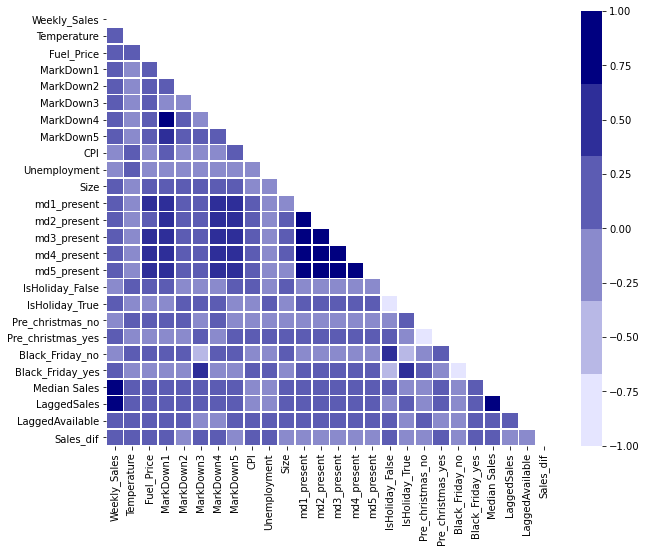

In [23]:
# Merge by store and department
df = df.merge(sorted_df[['Dept', 'Store','DateType','LaggedSales','LaggedAvailable']], \
              how = 'inner', on = ['Dept', 'Store','DateType'])

df=get_sales_diff(df)

plot_corr(df)


#We have our entire dataframe ready with all the pre-processing.
#However, we do not need all these features. We did all these 
#feature processing for us to understand the data better.
#Now, if we go all these features to the model, some of the features will be repeated. For example, 
#month and date (We do not date if we have month) Granularity at the date level is not needed

#We create the columns we need

In [24]:
cols_needed = [
    'Month',
    'CPI',
    'Fuel_Price',
    'MarkDown1',
    'MarkDown2',
    'MarkDown3',
    'MarkDown4',
    'MarkDown5',
    'Size',
    'Temperature',
    'Unemployment',
    
    
    
    'md1_present',
    'md2_present',
    'md3_present',
    'md4_present',
    'md5_present',
  'IsHoliday_False',
    'IsHoliday_True',
    'Pre_christmas_no',
    'Pre_christmas_yes',
    'Black_Friday_no',
    'Black_Friday_yes',    
    'LaggedSales',
    'Sales_dif',
    'LaggedAvailable'
    ]
data_model=df[cols_needed] #we store the data for model here

data_model.head()

,Month,CPI,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,Size,Temperature,...,md5_present,IsHoliday_False,IsHoliday_True,Pre_christmas_no,Pre_christmas_yes,Black_Friday_no,Black_Friday_yes,LaggedSales,Sales_dif,LaggedAvailable
0,8,136.213613,3.796,0.00,0.0,0.00,0.00,0.00,152513.0,61.10,...,False,1,0,1,0,1,0,87690.330,0.000,0.0
1,8,138.281452,3.874,4507.08,33.6,149.46,1866.46,4685.63,152513.0,62.08,...,True,1,0,1,0,1,0,87690.330,0.000,0.0
2,3,128.616064,3.480,0.00,0.0,0.00,0.00,0.00,158114.0,53.11,...,False,1,0,1,0,1,0,6648.130,-322.625,1.0
3,3,128.512193,3.495,0.00,0.0,0.00,0.00,0.00,158114.0,55.58,...,False,1,0,1,0,1,0,6325.505,0.000,0.0
4,3,128.264750,3.305,0.00,0.0,0.00,0.00,0.00,158114.0,46.21,...,False,1,0,1,0,1,0,6325.505,0.000,0.0


In [25]:
X_train,X_dev,y_train,y_dev,test,train=model_dataset_split(df)

print(X_dev.shape)
print(y_dev.shape)

rf_model=train_RandomForest(X_train, y_train)

(20627, 25)
(20627,)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 20


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.7s remaining:    0.0s


building tree 2 of 20
building tree 3 of 20
building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   48.3s finished


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.2s finished


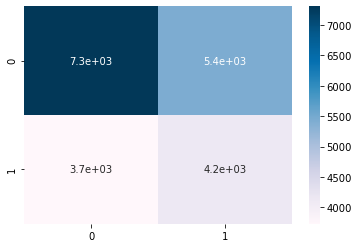

In [26]:
y_pred_random=predict_RandomForest(X_dev,rf_model)
y_dev = y_dev.to_frame()


# Transform forest predictions to observe direction of change
direction_true1= binary(y_dev.values)
direction_predict = binary(y_pred_random)

## show confusion matrix random forest
cnf_matrix = confusion_matrix(direction_true1, direction_predict)

fig, ax = plt.subplots(1)
ax = sns.heatmap(cnf_matrix, ax=ax, cmap=plt.cm.PuBu, annot=True)

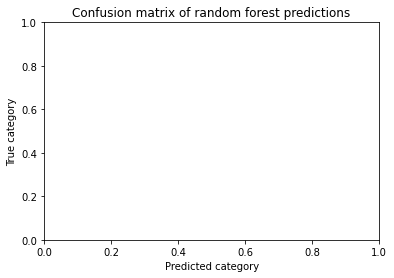

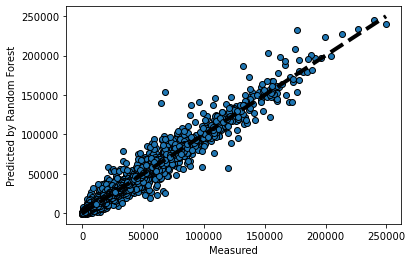

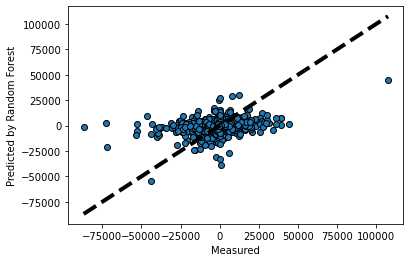

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 20


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.8s remaining:    0.0s


building tree 2 of 20
building tree 3 of 20
building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   59.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.5s finished


,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,...,Black_Friday_yes,Median Sales,Key,DateLagged,LaggedSales,LaggedAvailable,Sales_dif,Difference,0,prediction
0,Store_34,Dept_22,3/30/2012,0.0,IsHoliday_False,59.29,3.820,7866.57,104.84,5.59,...,0,6325.505,Type_ADept_22Store_343/30/2012IsHoliday_False,2012-03-23,6325.505,0.0,0.0,6325.505,394.22150,5931.28350
1,Store_34,Dept_22,3/9/2012,0.0,IsHoliday_False,42.70,3.667,6150.33,209.07,0.00,...,0,6325.505,Type_ADept_22Store_343/9/2012IsHoliday_False,2012-03-02,6325.505,0.0,0.0,6325.505,-68.13675,6393.64175
2,Store_19,Dept_55,5/13/2011,0.0,IsHoliday_False,54.20,4.211,0.00,0.00,0.00,...,0,8271.820,Type_ADept_55Store_195/13/2011IsHoliday_False,2011-05-06,8271.820,0.0,0.0,8271.820,1108.56100,7163.25900
3,Store_19,Dept_14,8/17/2012,0.0,IsHoliday_False,69.83,3.963,4512.60,370.35,11.11,...,0,16971.875,Type_ADept_14Store_198/17/2012IsHoliday_False,2012-08-10,16971.875,0.0,0.0,16971.875,-190.38250,17162.25750
4,Store_19,Dept_14,8/26/2011,0.0,IsHoliday_False,69.34,3.906,0.00,0.00,0.00,...,0,16971.875,Type_ADept_14Store_198/26/2011IsHoliday_False,2011-08-19,16971.875,0.0,0.0,16971.875,684.63025,16287.24475


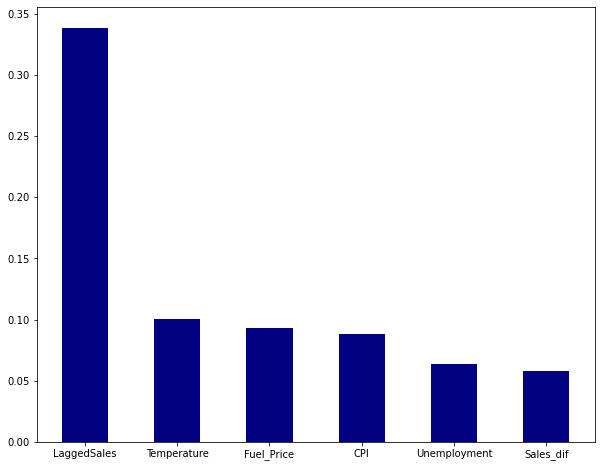

In [27]:


#ax.set_xticklabels(abbreviation)
#ax.set_yticklabels(abbreviation)
plt.title('Confusion matrix of random forest predictions')
plt.ylabel('True category')
plt.xlabel('Predicted category')
plt.show();


y_dev['Predicted'] = y_pred_random
df_out = pd.merge(train,y_dev[['Predicted']],how = 'left',left_index = True, right_index = True,suffixes=['_True','_Pred'])
df_out = df_out[~pd.isnull(df_out['Predicted'])]
df_out.head()

df_out['prediction'] = df_out['Median Sales']-df_out['Predicted']
plot_prediction(df_out['Weekly_Sales'],df_out['prediction'],"Random Forest")
plot_prediction(y_pred_random,y_dev['Difference'].values,"Random Forest")


df_out = results_randomForest(y_dev,train)

plot_feature_importance(data_model,cols_needed,rf_model) #get the features of top 5 significance

train.head()

rf_model=train_RandomForest(train[cols_needed], train['Difference'])

final_y_prediction = rf_model.predict(test[cols_needed])

testfile = pd.concat([test.reset_index(drop=True), pd.DataFrame(final_y_prediction)], axis=1)
testfile['prediction'] = testfile['Median Sales']-testfile[0]
testfile.head()


In [28]:
train.head()


,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,...,Pre_christmas_yes,Black_Friday_no,Black_Friday_yes,Median Sales,Key,DateLagged,LaggedSales,LaggedAvailable,Sales_dif,Difference
0,Store_26,Dept_92,8/26/2011,87235.57,IsHoliday_False,61.10,3.796,0.00,0.0,0.00,...,0,1,0,87690.330,Type_ADept_92Store_268/26/2011IsHoliday_False,2011-08-19,87690.330,0.0,0.000,454.760
1,Store_26,Dept_92,8/24/2012,88145.09,IsHoliday_False,62.08,3.874,4507.08,33.6,149.46,...,0,1,0,87690.330,Type_ADept_92Store_268/24/2012IsHoliday_False,2012-08-17,87690.330,0.0,0.000,-454.760
2,Store_34,Dept_22,3/25/2011,5945.97,IsHoliday_False,53.11,3.480,0.00,0.0,0.00,...,0,1,0,6325.505,Type_ADept_22Store_343/25/2011IsHoliday_False,2011-03-18,6648.130,1.0,-322.625,379.535
3,Store_34,Dept_22,3/18/2011,6648.13,IsHoliday_False,55.58,3.495,0.00,0.0,0.00,...,0,1,0,6325.505,Type_ADept_22Store_343/18/2011IsHoliday_False,2011-03-11,6325.505,0.0,0.000,-322.625
4,Store_34,Dept_22,3/4/2011,6393.82,IsHoliday_False,46.21,3.305,0.00,0.0,0.00,...,0,1,0,6325.505,Type_ADept_22Store_343/4/2011IsHoliday_False,2011-02-25,6325.505,0.0,0.000,-68.315


In [29]:
rf_model=train_RandomForest(train[cols_needed], train['Difference'])


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 20


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.2s remaining:    0.0s


building tree 2 of 20
building tree 3 of 20
building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   58.2s finished


In [30]:

final_y_prediction = rf_model.predict(test[cols_needed])

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.5s finished


In [31]:
testfile = pd.concat([test.reset_index(drop=True), pd.DataFrame(final_y_prediction)], axis=1)
testfile['prediction'] = testfile['Median Sales']-testfile[0]
testfile.head()


,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,...,Black_Friday_yes,Median Sales,Key,DateLagged,LaggedSales,LaggedAvailable,Sales_dif,Difference,0,prediction
0,Store_34,Dept_22,3/30/2012,0.0,IsHoliday_False,59.29,3.820,7866.57,104.84,5.59,...,0,6325.505,Type_ADept_22Store_343/30/2012IsHoliday_False,2012-03-23,6325.505,0.0,0.0,6325.505,24.67675,6300.82825
1,Store_34,Dept_22,3/9/2012,0.0,IsHoliday_False,42.70,3.667,6150.33,209.07,0.00,...,0,6325.505,Type_ADept_22Store_343/9/2012IsHoliday_False,2012-03-02,6325.505,0.0,0.0,6325.505,72.81750,6252.68750
2,Store_19,Dept_55,5/13/2011,0.0,IsHoliday_False,54.20,4.211,0.00,0.00,0.00,...,0,8271.820,Type_ADept_55Store_195/13/2011IsHoliday_False,2011-05-06,8271.820,0.0,0.0,8271.820,1173.29075,7098.52925
3,Store_19,Dept_14,8/17/2012,0.0,IsHoliday_False,69.83,3.963,4512.60,370.35,11.11,...,0,16971.875,Type_ADept_14Store_198/17/2012IsHoliday_False,2012-08-10,16971.875,0.0,0.0,16971.875,-392.98650,17364.86150
4,Store_19,Dept_14,8/26/2011,0.0,IsHoliday_False,69.34,3.906,0.00,0.00,0.00,...,0,16971.875,Type_ADept_14Store_198/26/2011IsHoliday_False,2011-08-19,16971.875,0.0,0.0,16971.875,652.81700,16319.05800
